In [1]:
import sys
import os
import numpy as np
from pathlib import Path

from dotenv import load_dotenv
load_dotenv()
# Add the project root directory to Python path
project_root = str(Path(os.getcwd()).parent)
if project_root not in sys.path:
    sys.path.append(project_root)
import pandas as pd
import matplotlib.pyplot as plt

from utils.plots import EDAPlots
from utils.eia_api import EIADataPuller
from utils.custom_types import StorageRegion, FuelType, EIAConsumptionType, storage_region_to_noaa_states
from utils.data_transforms import DataTransforms
from utils.noaa import get_noaa_day_data

# Program/Anaysis Constants

In [2]:
ANALYSIS_REGION = StorageRegion.EAST
data_puller = EIADataPuller(ANALYSIS_REGION)

# EIA Natural Gas Storage Numbers

In [3]:
storage_df = data_puller.get_storage_data()

print(f"\nDtypes: {storage_df.dtypes}")
storage_df

{'response': {'total': '345', 'dateFormat': 'YYYY-MM-DD', 'frequency': 'weekly', 'data': [{'period': '2019-01-18', 'duoarea': 'R31', 'area-name': 'NA', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'SWO', 'process-name': 'Underground Storage - Working Gas', 'series': 'NW2_EPG0_SWO_R31_BCF', 'series-description': 'Weekly East Region Natural Gas Working Underground Storage (Billion Cubic Feet)', 'value': '566', 'units': 'BCF'}, {'period': '2019-02-08', 'duoarea': 'R31', 'area-name': 'NA', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'SWO', 'process-name': 'Underground Storage - Working Gas', 'series': 'NW2_EPG0_SWO_R31_BCF', 'series-description': 'Weekly East Region Natural Gas Working Underground Storage (Billion Cubic Feet)', 'value': '444', 'units': 'BCF'}, {'period': '2019-05-03', 'duoarea': 'R31', 'area-name': 'NA', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'SWO', 'process-name': 'Underground Storage - Working Gas', 'series': 'NW2_EP

,EAST_NG_Storage_BCF,Week,Year
0,677,31,2025
1,656,30,2025
2,651,29,2025
3,634,28,2025
4,628,27,2025
...,...,...,...
340,468,4,2019
341,527,3,2019
342,566,2,2019
343,620,1,2019


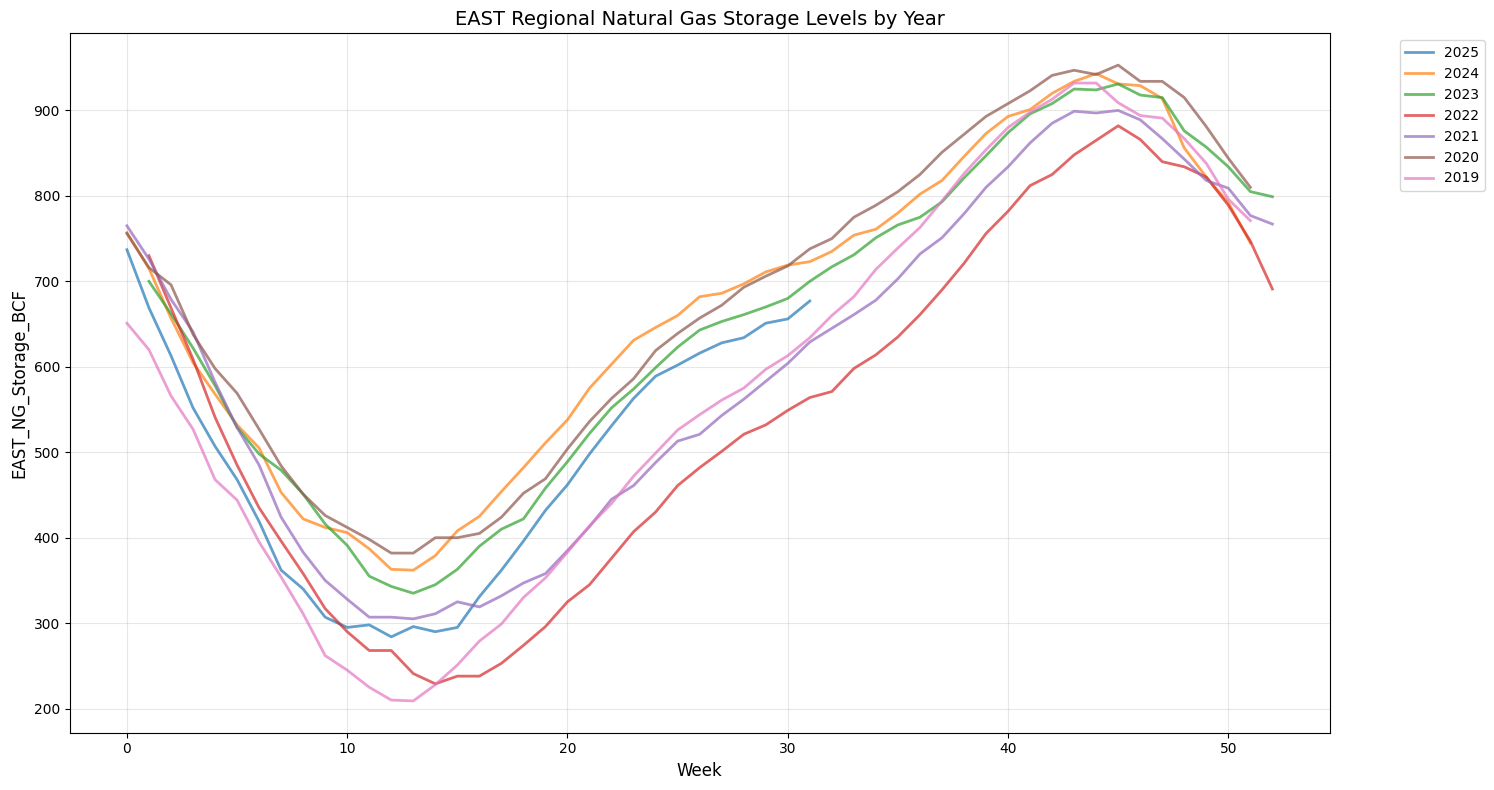

In [4]:
EDAPlots.generate_year_plot(storage_df, 'Week',f'{ANALYSIS_REGION.name}_NG_Storage_BCF', f"{ANALYSIS_REGION.name} Regional Natural Gas Storage Levels by Year")

# Power Generation

Pros: Power Generation from burnt fuel is very granual (daily)  
Cons: Data only extends back to 2019, we will simply graph this data to determine if any other series can be used as a replacement to allow us to use years before 2019

In [5]:
power_gen_df = data_puller.get_power_gen_data(FuelType.NATURAL_GAS)
print(f"\nDtypes: {power_gen_df.dtypes}")
power_gen_df

{'warnings': [{'warning': 'incomplete return', 'description': 'The API can only return 5000 rows in JSON format.  Please consider constraining your request with facet, start, or end, or using offset to paginate results.'}], 'response': {'total': '9667', 'dateFormat': 'YYYY-MM-DD', 'frequency': 'daily', 'data': [{'period': '2025-08-14', 'respondent': 'CAR', 'respondent-name': 'Carolinas', 'fueltype': 'NG', 'type-name': 'Natural Gas', 'timezone': 'Eastern', 'timezone-description': 'Eastern', 'value': '212706', 'value-units': 'megawatthours'}, {'period': '2025-08-14', 'respondent': 'MIDA', 'respondent-name': 'Mid-Atlantic', 'fueltype': 'NG', 'type-name': 'Natural Gas', 'timezone': 'Eastern', 'timezone-description': 'Eastern', 'value': '1387526', 'value-units': 'megawatthours'}, {'period': '2025-08-14', 'respondent': 'NE', 'respondent-name': 'New England', 'fueltype': 'NG', 'type-name': 'Natural Gas', 'timezone': 'Eastern', 'timezone-description': 'Eastern', 'value': '272363', 'value-units

,Week,Year,EAST_NG_Power_Gen_MWh
0,0,2019,9.004496e+05
1,0,2020,1.050378e+06
2,0,2021,1.181554e+06
3,0,2022,9.600410e+05
4,0,2024,1.585946e+06
...,...,...,...
346,52,2021,1.201993e+06
347,52,2022,1.214021e+06
348,52,2023,1.318246e+06
349,52,2024,1.221313e+06


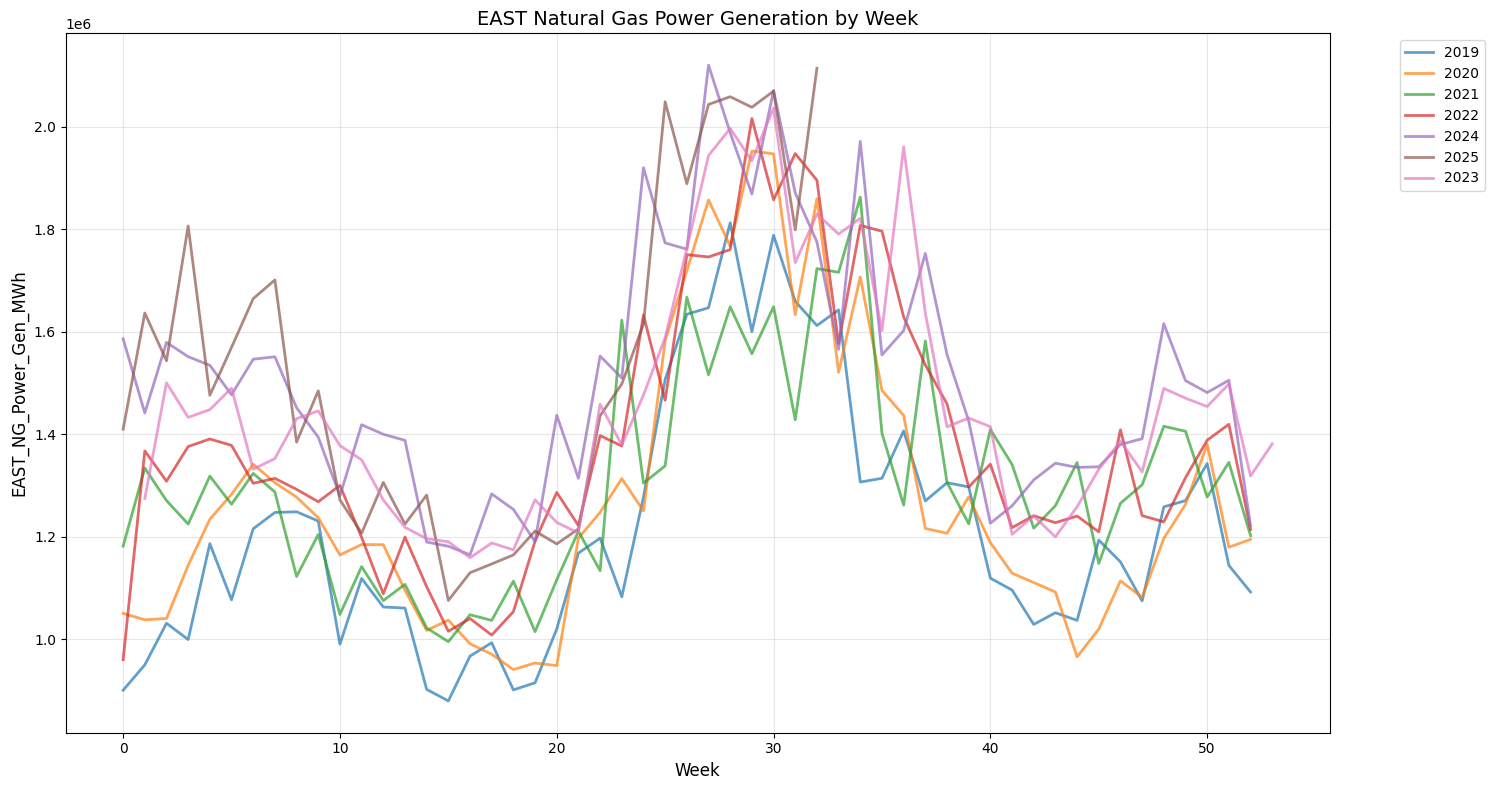

In [6]:
EDAPlots.generate_year_plot(power_gen_df, "Week", f"{ANALYSIS_REGION.name}_NG_Power_Gen_MWh", f"{ANALYSIS_REGION.name} Natural Gas Power Generation by Week")

# NG Usage Data

While there are many options for natural gas usage (all of which we will use for our model), we will take a look at the Elecricity consumption type to see if we can approximate the pattern provided by the EIA power burn dataset (peak in summer months, slight rise in Winter)

In [7]:
usage_type = EIAConsumptionType.ELECTRICITY
elecricity_usage_df = data_puller.get_ng_usage_data(usage_type)
elecricity_usage_df

{'response': {'total': '735', 'dateFormat': 'YYYY-MM', 'frequency': 'monthly', 'data': [{'period': '2005-05', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VEU', 'process-name': 'Electric Power Consumption', 'series': 'N3045NE2', 'series-description': 'Nebraska Natural Gas Deliveries to Electric Power Consumers (MMcf)', 'value': '496', 'units': 'MMCF'}, {'period': '2005-08', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VEU', 'process-name': 'Electric Power Consumption', 'series': 'N3045NE2', 'series-description': 'Nebraska Natural Gas Deliveries to Electric Power Consumers (MMcf)', 'value': '1316', 'units': 'MMCF'}, {'period': '2006-01', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VEU', 'process-name': 'Electric Power Consumption', 'series': 'N3045NE2', 'series-description': 'Nebraska Natural Gas Deliveries to Elec

,period,value,Year,Month
0,2005-01-01,63166,2005,1
1,2005-02-01,53246,2005,2
2,2005-03-01,68461,2005,3
3,2005-04-01,61816,2005,4
4,2005-05-01,75216,2005,5
...,...,...,...,...
240,2025-01-01,148935,2025,1
241,2025-02-01,128699,2025,2
242,2025-03-01,128840,2025,3
243,2025-04-01,136622,2025,4


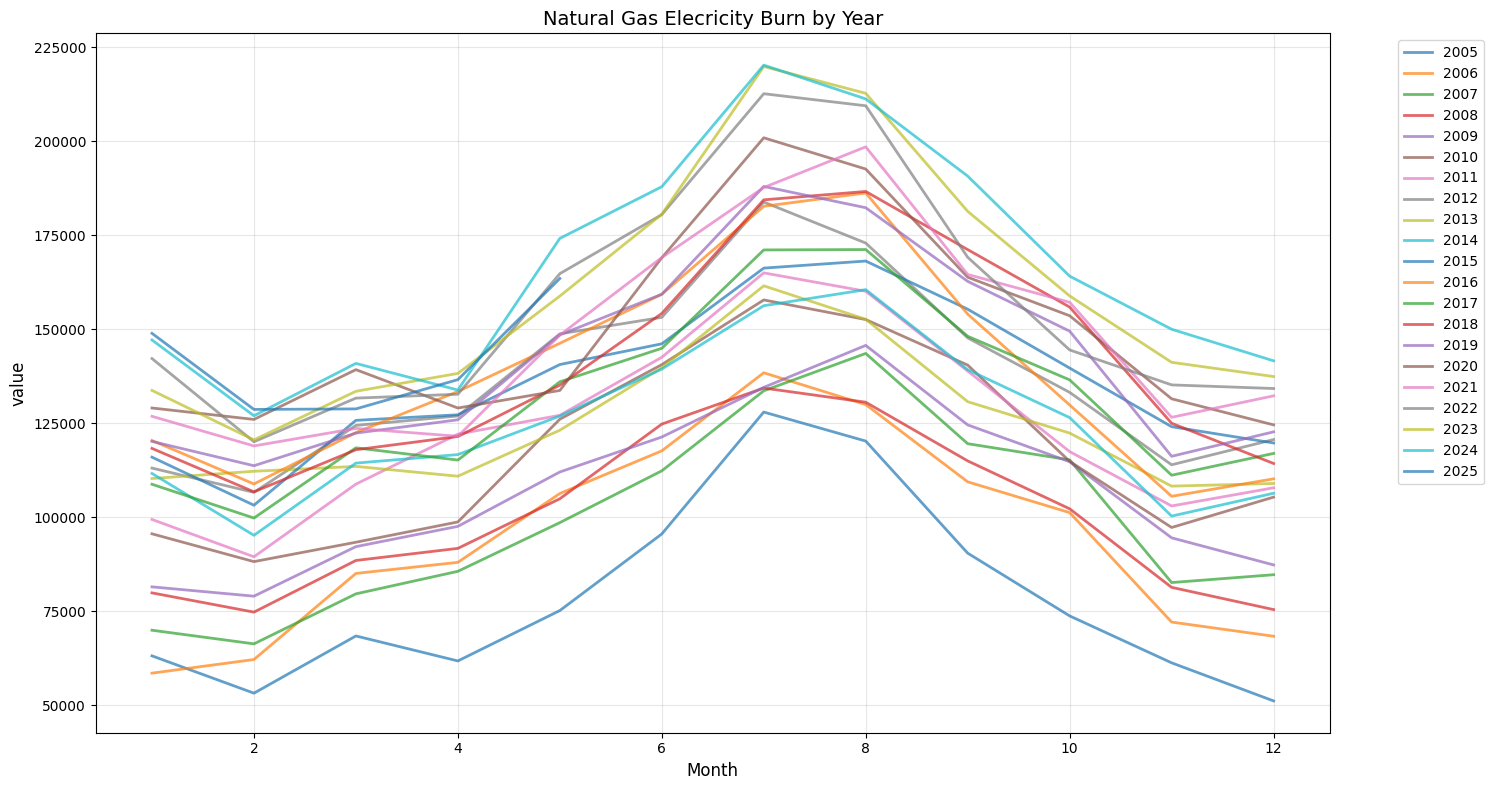

In [8]:
EDAPlots.generate_year_plot(elecricity_usage_df, "Month", "value", "Natural Gas Elecricity Burn by Year")

While the monthly NG consumption data does not represent the week to week fluctuations that occur for power generation, the overal trend of the time series is preserved, which is suitable for this type of seasonality analysis.

In [9]:
weekly_df = DataTransforms.upscale_monthly_to_weekly(elecricity_usage_df, "period", "value")
weekly_df

,period,Year,Month,Week,value
0,2005-01-02,2005,1,1,15791.5
1,2005-01-09,2005,1,2,15791.5
2,2005-01-16,2005,1,3,15791.5
3,2005-01-23,2005,1,4,15171.5
4,2005-01-30,2005,1,5,14551.5
...,...,...,...,...,...
1060,2025-04-27,2025,4,17,36845.1
1061,2025-05-04,2025,5,18,38189.9
1062,2025-05-11,2025,5,19,39534.7
1063,2025-05-18,2025,5,20,40879.5


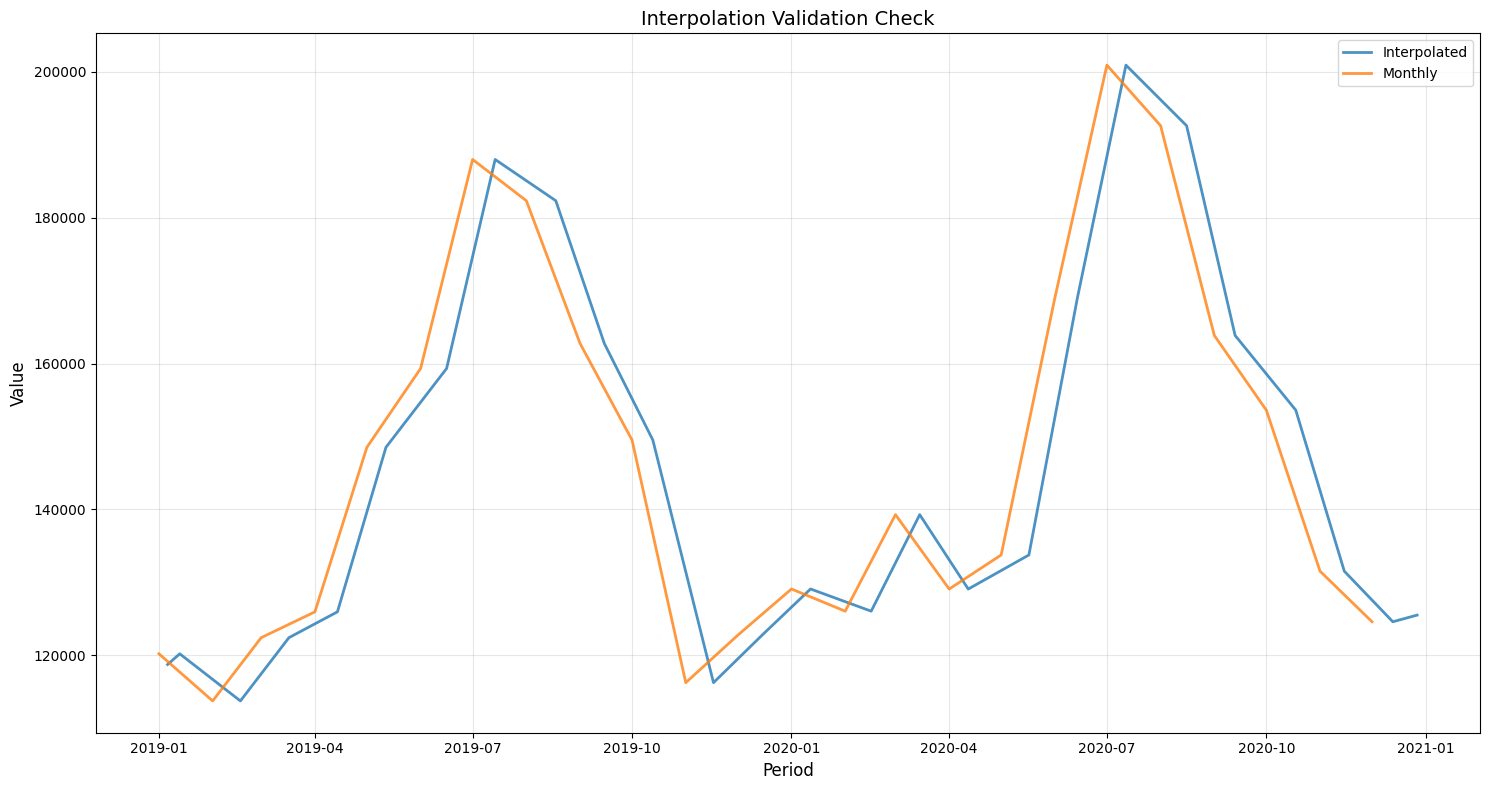

In [10]:
check_year = 2019
EDAPlots.plot_dual_time_series_separate_dfs(
    title="Interpolation Validation Check", 
    df1=weekly_df[(weekly_df['Year'] == check_year) | (weekly_df['Year'] == check_year + 1)].assign(value=lambda x: x['value'] * 4), 
    series1_col="value", 
    df2=elecricity_usage_df[(elecricity_usage_df['Year'] == check_year) | (elecricity_usage_df['Year'] == check_year + 1)], 
    series2_col="value", 
    series1_label="Interpolated", 
    series2_label="Monthly"
)

The Interpolated graph is shifted to the right of the monthly series graph. Since we are centering the monthly time series on the middle week of every month, this is expected.

In [11]:
weekly_deviation_df = DataTransforms.calculate_deviation_from_yearly_avg(weekly_df, "period", "value")
weekly_deviation_df

,period,Year,Month,Week,value,year,yearly_avg,deviation
0,2005-01-02,2005,1,1,15791.5,2005,19791.063702,-20.208938
1,2005-01-09,2005,1,2,15791.5,2005,19791.063702,-20.208938
2,2005-01-16,2005,1,3,15791.5,2005,19791.063702,-20.208938
3,2005-01-23,2005,1,4,15171.5,2005,19791.063702,-23.341665
4,2005-01-30,2005,1,5,14551.5,2005,19791.063702,-26.474392
...,...,...,...,...,...,...,...,...
1060,2025-04-27,2025,4,17,36845.1,2025,35205.809524,4.656307
1061,2025-05-04,2025,5,18,38189.9,2025,35205.809524,8.476131
1062,2025-05-11,2025,5,19,39534.7,2025,35205.809524,12.295955
1063,2025-05-18,2025,5,20,40879.5,2025,35205.809524,16.115779


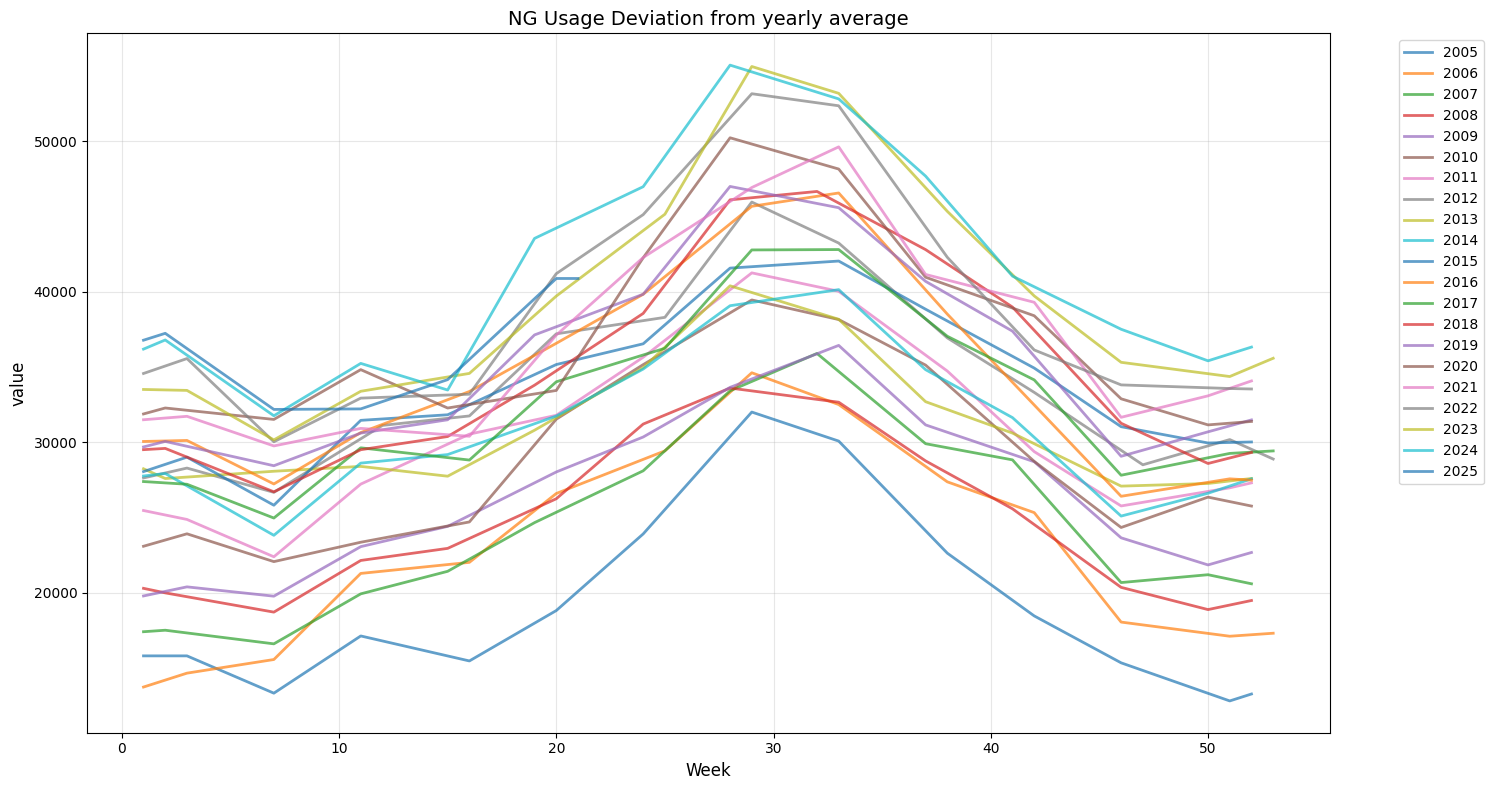

In [13]:
EDAPlots.generate_year_plot(weekly_deviation_df, "Week", "value", 'NG Usage Deviation from yearly average')

# NOAA Heating/Cooling Day Data

In [3]:

data = get_noaa_day_data(2010, 2024, storage_region_to_noaa_states[StorageRegion.EAST])

Getting data for 2010
Getting data for 2011
Getting data for 2012
Getting data for 2013
Getting data for 2014
Getting data for 2015
Getting data for 2016
Getting data for 2017
Getting data for 2018
Getting data for 2019
Getting data for 2020
Getting data for 2021
Getting data for 2022
Getting data for 2023
Getting data for 2024


In [4]:
data.sort_values(by=["Heating_Days", "Cooling_Days"], ascending=True)

,Week,Heating_Days,Cooling_Days,Year
29,29,0,1143,2024
30,30,0,1259,2018
28,29,0,1301,2023
27,27,0,1330,2013
31,32,0,1331,2012
...,...,...,...,...
51,52,5018,15,2017
8,8,5106,19,2015
3,3,5271,0,2014
0,0,5387,0,2018


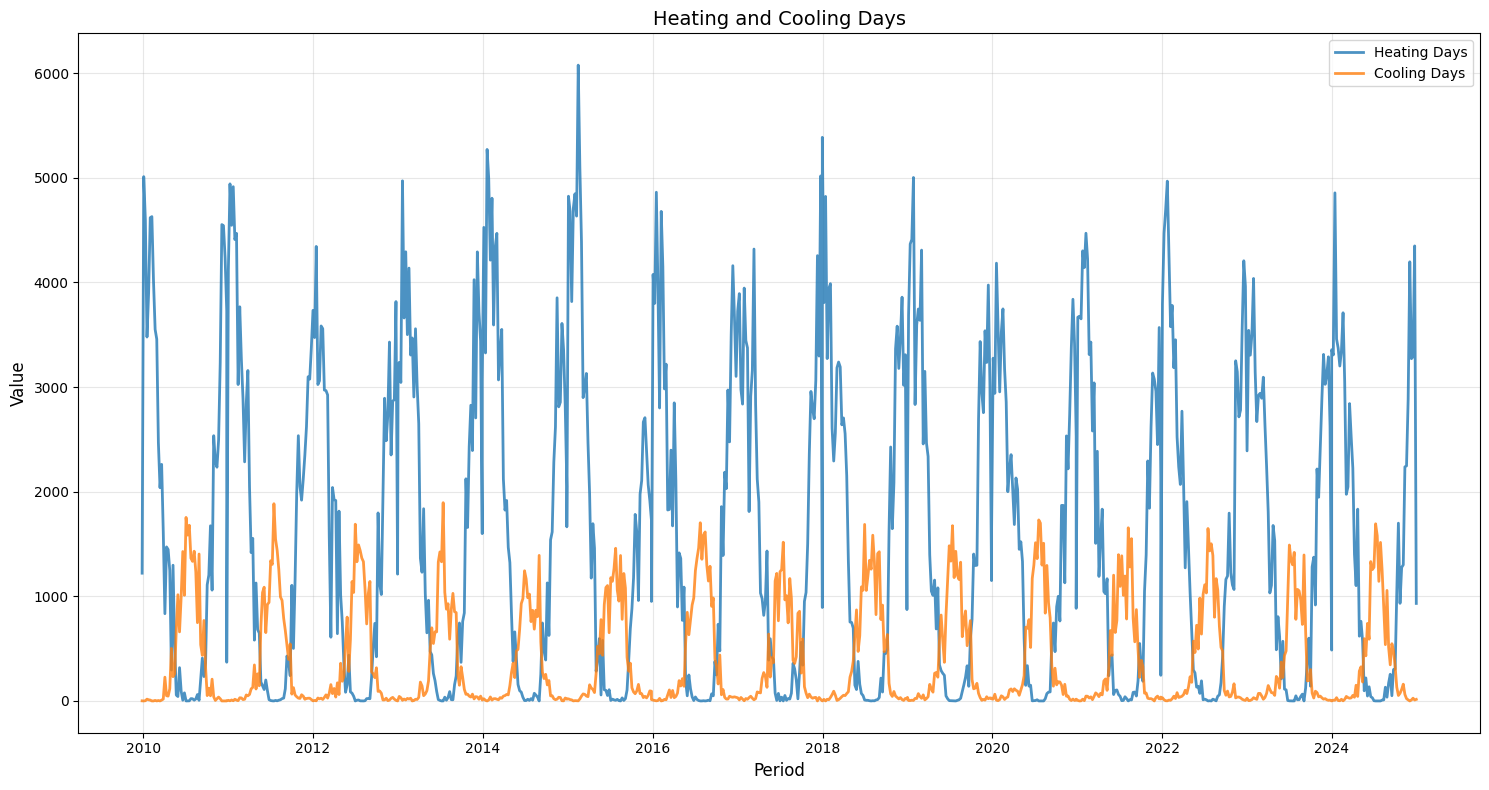

In [5]:
degree_days_plot_df = data.copy()
degree_days_plot_df['period'] = pd.to_datetime(data['Year'].astype(str) + data['Week'].astype(str).str.zfill(2) + '0', format='%Y%U%w')
EDAPlots.plot_dual_time_series_separate_dfs(
    title="Heating and Cooling Days", 
    df1=degree_days_plot_df, 
    series1_col="Heating_Days", 
    df2=degree_days_plot_df, 
    series2_col="Cooling_Days", 
    series1_label="Heating Days", 
    series2_label="Cooling Days"
)

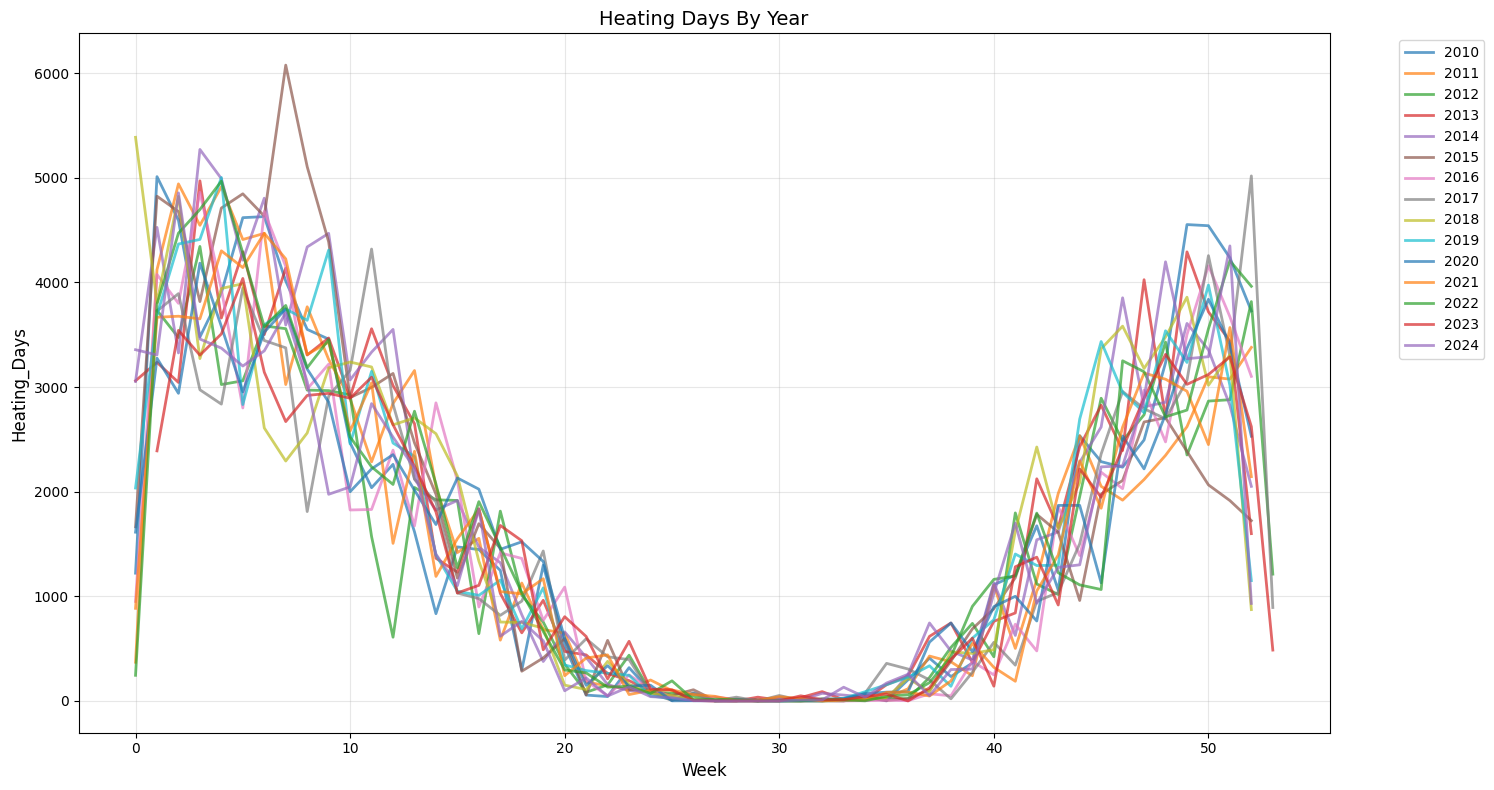

In [9]:
EDAPlots.generate_year_plot(degree_days_plot_df, "Week", "Heating_Days", "Heating Days By Year")